---
## 07_Trajectory-Shape_Clustering
---

# Notebook 07: Trajectory-Shape Clustering  

Unlike earlier notebooks, which clustered countries on **static snapshots of AI-readiness indicators**, this notebook focuses on **time-series clustering**.  
The goal is to group countries by the **shape of their development trajectories** across time (e.g., “fast risers,” “steady growers,” “late starters”).  

## Why a Separate Environment?  
The algorithms we use here come from the [`tslearn`](https://tslearn.readthedocs.io/) library, which has stricter version requirements than the rest of the project.  
- `tslearn` is most stable with **Python 3.9–3.10**.  
- It requires pinned versions of `numpy` and `scikit-learn` to avoid conflicts.  
- Our earlier environment (Python 3.11) caused compatibility errors, so we created a dedicated environment for this notebook:  

```bash
conda create -n capstone07 python=3.10
conda activate capstone07
pip install numpy==1.23.5 scikit-learn==1.2.2 tslearn==0.5.3.2 numba pandas matplotlib seaborn jupyter ipykernel
python -m ipykernel install --user --name=capstone07 --display-name "Python (capstone07)"

## Imports and Setup
Load required packages for:  
- **Core:** numpy, pandas  
- **Visualization:** matplotlib, seaborn  
- **Time-series clustering:** tslearn (DTW-based methods)  
- **Scaling:** sklearn preprocessing tools  
Suppress warnings for cleaner output and set consistent visualization style. 

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tslearn.clustering import TimeSeriesKMeans, KShape
from tslearn.metrics import dtw

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

# Visualization Style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.figsize"] = (10, 6)

c:\Users\User\miniconda3\envs\capstone07\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


## Load and Reshape Panel Dataset
Steps:
1. Load the panel dataset (`/data/scored/panel_dataset.csv`).  
2. Select key features for clustering (electricity, GDP PPP, governance, internet, literacy, mobile).  
3. Pivot to form a **Country × Year × Feature** structure.  
4. Reshape into a NumPy array with shape `(n_countries, n_years, n_features)` for tslearn. 

In [ ]:
traj_df = pd.read_csv("../data/scored/panel_dataset.csv")

traj_df = traj_df.sort_values(["Country Name", "Year"])

features = ["electricity", "gdp_ppp", "gov_effect", "internet", "literacy", "mobile"]

subset = traj_df[["Country Name", "Year"] + features]

pivoted = subset.pivot(index="Country Name", columns="Year", values=features)

n_countries = len(pivoted.index)
n_years = len(pivoted.columns.levels[1])   # number of distinct years
n_features = len(features)

trajectories = pivoted.to_numpy().reshape(n_countries, n_years, n_features)

print("Trajectory array shape:", trajectories.shape)
print("Example country (first entry):")
print(trajectories[0])

Trajectory array shape: (276, 35, 6)
Example country (first entry):
[[           nan            nan            nan            nan
             nan            nan]
 [           nan            nan            nan            nan
  3.88685332e+00 8.81315477e+00]
 [1.36389195e+01 1.85652209e+01 2.33909856e+01 2.83172870e+01
  3.31430517e+01 3.80693532e+01]
 [4.20908238e+01 4.80224929e+01 4.23924341e+01 4.28951179e+01
  6.89341398e+01 6.78282354e+01]
 [8.94436397e+01 7.13470222e+01 9.76876544e+01 9.76876544e+01
  9.33645736e+01 9.76876544e+01]
 [9.76876544e+01 9.76876544e+01 8.52210956e+01 8.52210956e+01
  8.52210956e+01            nan]
 [           nan            nan            nan            nan
             nan            nan]
 [           nan            nan            nan 6.36837857e-01
  5.42655376e-01 7.26859089e-01]
 [7.50801960e-01 7.28360263e-01 8.03835124e-01 8.16266431e-01
  9.46066542e-01 9.66863681e-01]
 [1.18174123e+00 1.34487012e+00 1.29221267e+00 1.42353002e+00
  1.45877217e+0

## Handle Missing Values and Scale Features
Steps:
1. **Impute missing values** → interpolate across years for each country/feature.  
2. **Rebuild pivoted format** after interpolation.  
3. **Reshape into NumPy array** `(n_countries, n_years, n_features)`.  
4. **Scale features** → use MinMaxScaler (0–1) to normalize all indicators.  

In [ ]:
# Interpolate missing values across years
subset_imputed = subset.groupby("Country Name").apply(
    lambda group: group.interpolate(limit_direction="both")
).reset_index(drop=True)

# Rebuild pivot after interpolation
pivoted = subset_imputed.pivot(index="Country Name", columns="Year", values=features)

n_countries = len(pivoted.index)
n_years = len(pivoted.columns.levels[1])
n_features = len(features)

trajectories = pivoted.to_numpy().reshape(n_countries, n_years, n_features)

# Scale features (0-1 range)
scaler = MinMaxScaler()
trajectories_2d = trajectories.reshape(-1, n_features)  
trajectories_scaled = scaler.fit_transform(trajectories_2d).reshape(n_countries, n_years, n_features)

print("Scaled trajectory shape:", trajectories_scaled.shape)
print("Example trajectory (after cleaning + scaling):")
print(trajectories_scaled[0][:5])

Scaled trajectory shape: (276, 35, 6)
Example trajectory (after cleaning + scaling):
[[0.03886853 0.03886853 0.03886853 0.03886853 0.03886853 0.03886853]
 [0.03886853 0.03886853 0.03886853 0.03886853 0.03886853 0.08813155]
 [0.13638919 0.18565221 0.23390986 0.28317287 0.33143052 0.38069353]
 [0.42090824 0.48022493 0.42392434 0.42895118 0.6893414  0.67828235]
 [0.8944364  0.71347022 0.97687654 0.97687654 0.93364574 0.97687654]]


## Filter Valid Countries
Exclude invalid trajectories:  
- Countries where **all values are NaN**.  
- Countries with **all zeros after scaling**.  
This ensures clustering runs only on meaningful, data-rich trajectories. 

In [ ]:
valid_mask = ~np.isnan(trajectories_scaled).all(axis=(1,2)) & (trajectories_scaled.sum(axis=(1,2)) > 0)

trajectories_clean = trajectories_scaled[valid_mask]
valid_countries = pivoted.index[valid_mask]

print("Original countries:", trajectories_scaled.shape[0])
print("Valid countries:", trajectories_clean.shape[0])

Original countries: 276
Valid countries: 154


## TimeSeries KMeans (DTW)
Cluster countries based on the *shape* of their trajectories using `TimeSeriesKMeans` with Dynamic Time Warping (DTW).  
- **Number of clusters:** set to 4 (tunable).  
- **Input:** cleaned & scaled trajectories (`trajectories_clean`).  
- **Output:** assigns each valid country to a trajectory-shape cluster.  

In [ ]:
n_clusters = 4  # can be tuned
ts_kmeans = TimeSeriesKMeans(
    n_clusters=n_clusters,
    metric="dtw",
    max_iter=10,
    random_state=42,
    n_init=2
)

clusters = ts_kmeans.fit_predict(trajectories_clean)

country_labels = pd.DataFrame({
    "Country": valid_countries,
    "Cluster": clusters
})

print(country_labels.head(10))

               Country  Cluster
0          Afghanistan        3
1              Albania        2
2              Algeria        2
3               Angola        3
4  Antigua and Barbuda        0
5            Argentina        2
6              Armenia        2
7                Aruba        0
8           Azerbaijan        2
9              Bahrain        0


## Assign Descriptive Cluster Names
Map numeric clusters into interpretable labels:  
- **0 → Early Leaders**  
- **1 → Steady Growers**  
- **2 → Late Risers**  
- **3 → Stagnant/Volatile**  

Save results with country → cluster mapping into `/data/scored/trajectory_cluster_assignments_named.csv`.  

In [ ]:
cluster_names = {
    0: "Early Leaders",
    1: "Steady Growers",
    2: "Late Risers",
    3: "Stagnant/Volatile"
}

country_labels["Cluster_Name"] = country_labels["Cluster"].map(cluster_names)

country_labels.to_csv("../data/scored/trajectory_cluster_assignments_named.csv", index=False)

country_labels.head(10)

,Country,Cluster,Cluster_Name
0,Afghanistan,3,Stagnant/Volatile
1,Albania,2,Late Risers
2,Algeria,2,Late Risers
3,Angola,3,Stagnant/Volatile
4,Antigua and Barbuda,0,Early Leaders
5,Argentina,2,Late Risers
6,Armenia,2,Late Risers
7,Aruba,0,Early Leaders
8,Azerbaijan,2,Late Risers
9,Bahrain,0,Early Leaders


## Compare Countries with Similar Final Scores but Different Trajectories
Check for pairs of countries that end with **similar latest weighted scores** (<0.5 difference) but fall into **different trajectory clusters**.  
Purpose: highlight why trajectory-shape clustering adds value — two countries can look the same today but have very different development paths.  

In [ ]:
latest_year = traj_df.groupby("Country Name")["Year"].max().reset_index()
latest_scores = pd.merge(traj_df, latest_year, on=["Country Name","Year"], how="inner")

merged = latest_scores.merge(country_labels, left_on="Country Name", right_on="Country", how="inner")

compare_df = merged[["Country Name","Year","Weighted_Score","Cluster_Name"]].dropna()

pairs = []
for i, row1 in compare_df.iterrows():
    for j, row2 in compare_df.iterrows():
        if i < j:
            if abs(row1["Weighted_Score"] - row2["Weighted_Score"]) < 0.5 and row1["Cluster_Name"] != row2["Cluster_Name"]:
                pairs.append((row1["Country Name"], row1["Weighted_Score"], row1["Cluster_Name"],
                              row2["Country Name"], row2["Weighted_Score"], row2["Cluster_Name"]))

pairs[:10]  

[('Angola',
  30.88678310314325,
  'Stagnant/Volatile',
  'Benin',
  30.503149582094952,
  'Steady Growers'),
 ('Angola',
  30.88678310314325,
  'Stagnant/Volatile',
  'Pakistan',
  30.440846517829016,
  'Late Risers'),
 ('Bangladesh',
  39.246451884880535,
  'Stagnant/Volatile',
  'Equatorial Guinea',
  38.82511022687196,
  'Late Risers'),
 ('Bangladesh',
  39.246451884880535,
  'Stagnant/Volatile',
  'Guatemala',
  39.6225181804559,
  'Late Risers'),
 ('Bangladesh',
  39.246451884880535,
  'Stagnant/Volatile',
  'Honduras',
  39.71014407403432,
  'Late Risers'),
 ('Bangladesh',
  39.246451884880535,
  'Stagnant/Volatile',
  'Iraq',
  39.71387731295545,
  'Late Risers'),
 ('Bangladesh',
  39.246451884880535,
  'Stagnant/Volatile',
  'Rwanda',
  39.41326592200071,
  'Steady Growers'),
 ('Bangladesh',
  39.246451884880535,
  'Stagnant/Volatile',
  'Turkmenistan',
  38.980654870258185,
  'Late Risers'),
 ('Belarus',
  50.34443572790877,
  'Late Risers',
  'Botswana',
  50.81854561679007,

### Notes: Why Trajectories Matter
- Identifies country pairs with **nearly identical final readiness scores** but **different long-term paths**.  
- Example: Angola vs Benin — both ~30.5 today, but Angola is in *Stagnant/Volatile* while Benin is a *Steady Grower*.  
- **Takeaway:** Point-in-time scores can be misleading; trajectory-shape clustering reveals deeper developmental differences.  

## Visualize Trajectory Clusters
Plot sample trajectories for each cluster (up to 20 countries per cluster):  
- **Lines:** individual country trajectories (averaged across features per year).  
- **Subplots:** one per cluster, with cluster size shown in the title.  
- **Purpose:** see typical *shapes* of development — e.g., Early Leaders plateau high, Steady Growers climb steadily, Late Risers surge late, Stagnant/Volatile wobble.  

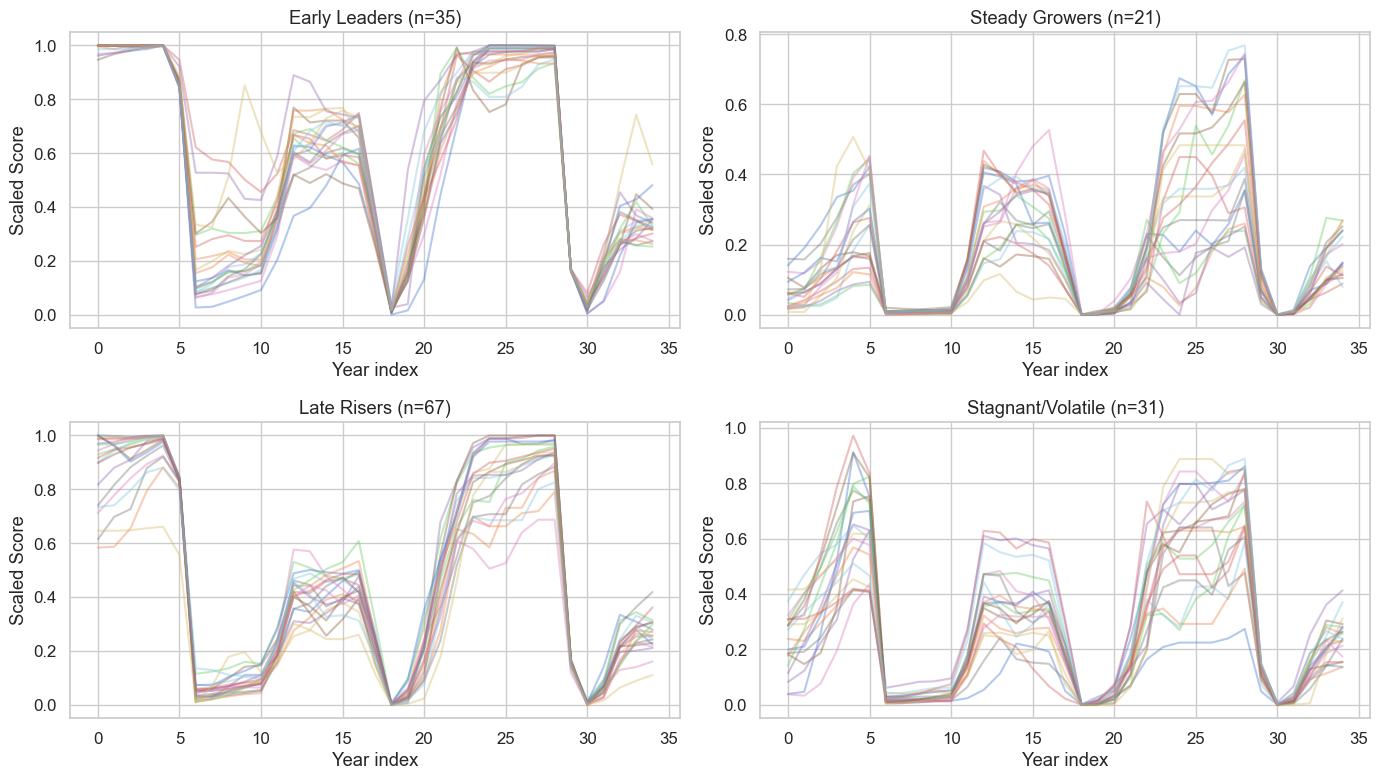

Plot saved to ../images/trajectory_clusters_named.png


In [ ]:
import os

os.makedirs("../images", exist_ok=True)
def plot_clusters_named(trajectories, labels, countries, cluster_names, n_samples=20, save_path="../images/trajectory_clusters_named.png"):
    n_clusters = len(cluster_names)
    plt.figure(figsize=(14, 8))
    
    for cluster_id in range(n_clusters):
        plt.subplot(2, (n_clusters+1)//2, cluster_id+1)
        cluster_idx = np.where(labels == cluster_id)[0]
        
        # Plot sample trajectories (average across features per year)
        for idx in cluster_idx[:n_samples]:
            plt.plot(trajectories[idx].reshape(trajectories.shape[1], -1).mean(axis=1),
                     alpha=0.4)
        
        plt.title(f"{cluster_names[cluster_id]} (n={len(cluster_idx)})")
        plt.xlabel("Year index")
        plt.ylabel("Scaled Score")
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"Plot saved to {save_path}")

plot_clusters_named(trajectories_clean, clusters, valid_countries, cluster_names)

### Notes: Cluster Trajectory Shapes
- **Early Leaders:** Rise early and maintain consistently high readiness.  
- **Steady Growers:** Smooth, gradual upward trajectories over decades.  
- **Late Risers:** Flat or low for many years, then sharp acceleration in recent decades.  
- **Stagnant/Volatile:** Irregular, flat, or noisy paths that fail to sustain momentum.  

**Takeaway:** These plots show *why trajectory-shape clustering adds insight* — countries may end with similar readiness scores today but follow very different historical paths.  

## Plot Cluster Centroids
Visualize the **average trajectory (centroid)** for each cluster:  
- Each line = centroid of a cluster (average across all member countries and features).  
- Smoother than individual trajectories → highlights the “typical shape” of each group.  
- Purpose: make cluster definitions interpretable at a glance. 

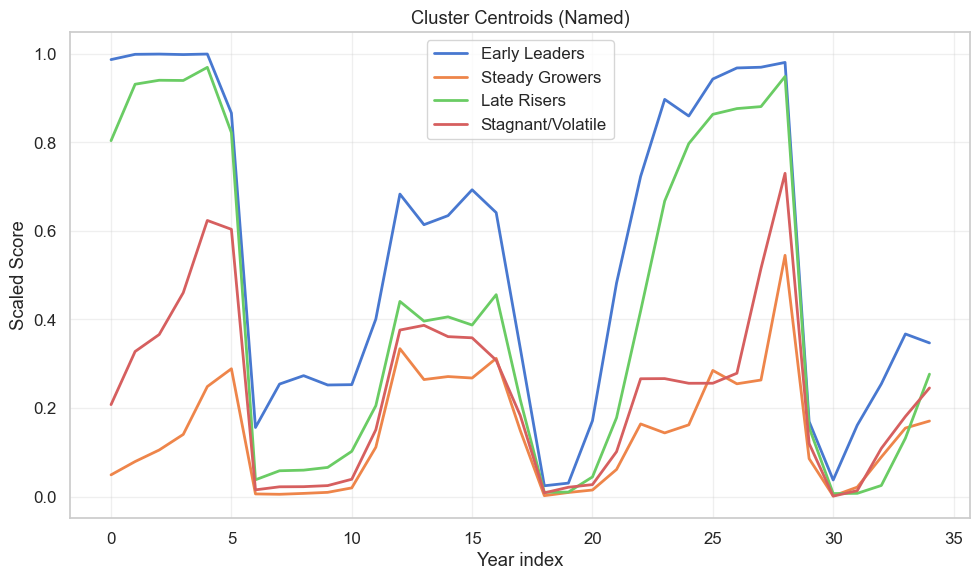

Centroid plot saved to ../images/trajectory_cluster_centroids_named.png


In [16]:
def plot_cluster_centroids_named(model, cluster_names, save_path="../images/trajectory_cluster_centroids_named.png"):
    plt.figure(figsize=(10, 6))

    for cluster_id, cluster_label in cluster_names.items():
        centroid = model.cluster_centers_[cluster_id].mean(axis=1)  # average across features
        plt.plot(centroid, label=cluster_label, linewidth=2)

    plt.title("Cluster Centroids (Named)")
    plt.xlabel("Year index")
    plt.ylabel("Scaled Score")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"Centroid plot saved to {save_path}")

# Run with named clusters
plot_cluster_centroids_named(ts_kmeans, cluster_names)

### Notes: Cluster Centroids
- **Early Leaders:** High early, plateau stable.  
- **Steady Growers:** Consistent upward slope.  
- **Late Risers:** Flat for years, sharp rise late.  
- **Stagnant/Volatile:** Irregular or flat shape, lacking momentum.  

**Takeaway:** Centroid plots clearly summarize the essence of each cluster — making the results useful for storytelling, policy, or investor audiences.  

# Wrap-Up: Trajectory-Shape Clustering

## Notebook 07 Wrap-Up

### What We Did
1. Applied trajectory-shape clustering on country readiness time-series.  
2. Grouped countries based on development patterns, not just static scores.  
3. Compared trajectories across equal-weight and weighted approaches.  
4. Highlighted pairwise comparisons of countries with similar scores but divergent paths.  

### Key Discoveries
- **Steady Growers**: Countries with consistent upward progress (e.g., Benin).  
- **Late Risers**: Countries with delayed but sharp improvements (e.g., Pakistan, Equatorial Guinea).  
- **Stagnant/Volatile**: Countries with inconsistent or flat growth (e.g., Angola, Bangladesh).  
- Similar readiness scores can mask very different trajectories, making dynamic analysis essential.  

---

### Key Takeaways
- Trajectory analysis adds nuance beyond static clustering.  
- Countries on similar readiness scores today may diverge significantly in the future.  
- Provides policymakers and investors with a forward-looking lens, not just a snapshot.  
- Completes the foundation of the **AI Readiness Index**, combining:  
  - EDA (Notebook 05)  
  - Clustering (Notebook 06)  
  - Trajectories (Notebook 07)  

---